<p align="center">
<img alt="logo" src="https://upload.wikimedia.org/wikipedia/ar/thumb/1/16/Birzeit_University_logo.svg/320px-Birzeit_University_logo.svg.png"/>
<br>
Faculty of Engineering and Technology<br>
Electrical and Computer Engineering Department<br></p>
<hr>
<hr>
<p align="center">
ENCS5343 Computer Vision<br>
<br>
Assignment #2<br>
Content-Based Image Retrieval (CIBR)<br>
<br>
Student Name: Maysam Khatib<br>
Student ID: 1190207
</p>
<hr>

# **ENCS5343 Computer Vision - Assignment \#2**

link (just in case): [1190207_Maysam_Assignment2_CV.ipynp](https://colab.research.google.com/drive/19uVpwAwiWTV_7hQP5kOskzIyRWBqxxPG?usp=drive_link)

## **Introduction**

Content-Based Image Retrieval which known also as CBIR, is a method of retreiving the most relevent images to a query image, from a database based on the images' content.

This method compares the content of each image from the database to the query image and calculate the similarities. The content of the image can be colors, shapes, textures, spatial relations, etc.

The color features are one of the most obvious features, the ditribution of colors in the image can reveal important information about the image content. Comparing with other fetaures used methods, this one is considered robust, reliable, and simple. The color features are not sensitive to scale changing, and rotation. Also, what distinguishes this method is the simplicity of the implementation and the computation which made it one of the effictive methods of retreiving images based on the content features.

Two essential approaches are used for extracting the color features:


### **1. Color Histogram**


The color histogram describes the distribution of colors within an image. It quantifies the pixel intensity distribution inside a discretized color space. The histogram counts the amount of pixels that fall into each pin, providing a statistical definition of the image's color palette.

In other words, the value for each pin in the histogram represents the frequency of color pixels falling within the specified range. To calculate the normalized value for each pin:



$
\frac{\text{Number of Color Pixels in Pin's Range}}{\text{Total Number of Pixels in the Image}}
$


### **2. Color Moments**

while color histogram represnts the distribution of each color, the color moments represent the statitical aspects of this distribution by acquiring multiple characteristics of the color data, such as the mean, standard deviation, skewness, and other metrics of color channels. These moments contribute to the overall color characteristics and structures of an image.

Color moments are calculated by computing the statistical measures for each color channel (RGB channels). For each channel, the moments are calculated, yielding a collection of values that compose the color moment feature vector.

The most-used color moments are:

*   Mean (μ): the average intensity of color pixels in a channel.
*   Standard Deviation (σ): the spread of color values.
*   Skewness (γ): the asymmetry of the color distribution.

There are many other moments such as median (the middle value of a dataset when it is sorted), mode (the most frequent value), and kurtosis ( the tailedness of a probability distribution). Also weights can be added to give each moment a specific weight in calculations and to give some moments a priority than others.


### **Similarity Calculations**


To calculate the simialrity (distance) between two images:

* Manhatten Distance:

$
dist(h,l)=\sqrt{\sum_{k=1}^K{|h_k-l_k|}}
$

* Euclidean Distance:

$
dist(h,l)=\sqrt{\sum_{k=1}^K{(h_k-l_k)^2}}
$

## **Download the dataset**

The dataset was downloaded and extracted to be used in the CBIR system. The used dataset here is Wang dataset. This dataset contains 1000 images categorized to 10 categories, each category contains 100 images (1 -> 0-99, 2 -> 100-199, etc)


In [1]:
import os # for dealing with files and directories

# download the wang dataset
wang_dataset_url = 'http://wang.ist.psu.edu/~jwang/test1.zip'
zip_file_name = 'test1.zip'
dataset_folder_name = 'image.orig'

# check if the dataset folder is existed (to not download it again)
if not os.path.exists(dataset_folder_name):

    # check if the zip file is existed
    if not os.path.exists(zip_file_name):
        !wget $wang_dataset_url

    !unzip $zip_file_name
    # Remove the zip file after extraction
    os.remove(zip_file_name)
else:
    print("Dataset is already existed")

--2024-01-08 19:37:46--  http://wang.ist.psu.edu/~jwang/test1.zip
Resolving wang.ist.psu.edu (wang.ist.psu.edu)... 130.203.136.124
Connecting to wang.ist.psu.edu (wang.ist.psu.edu)|130.203.136.124|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://wang.ist.psu.edu/~jwang/test1.zip [following]
--2024-01-08 19:37:47--  https://wang.ist.psu.edu/~jwang/test1.zip
Connecting to wang.ist.psu.edu (wang.ist.psu.edu)|130.203.136.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29813239 (28M) [application/zip]
Saving to: ‘test1.zip’

test1.zip           100%[===================>]  28.43M  9.58MB/s    in 3.0s    

2024-01-08 19:37:51 (9.58 MB/s) - ‘test1.zip’ saved [29813239/29813239]

Archive:  test1.zip
  inflating: image.orig/0.jpg        
  inflating: image.orig/1.jpg        
  inflating: image.orig/10.jpg       
  inflating: image.orig/100.jpg      
  inflating: image.orig/101.jpg      
  inflating: image.orig/102.jpg

## **Task 1: Sytem Building**
Build the CBIR system: Design and implement a system architecture for image retrieval using color features. Develop functionalities for loading images, extracting features, computing distances, and ranking results.

### **CBIR System Overall Architecture**

The Content-Based Image Retrieval (CBIR) system has a modular architecture with diverse functionalities built into its functions. The system is initialized with the dataset's path, and the `load_images` method organizes the images and uses OpenCV to read and save each image. The system supports a variety of feature extraction methods, including color and texture-based approaches.

The `get_color_histogram` method concentrates on color features by dividing the input image into three color channels, calculating normalized histograms for each, and concatenating them into a final feature vector. Another color-based approach is used in the `get_color_moments` method, which calculates statistical moments with specific weights (mean, standard deviation, skewness, median, mode, and kurtosis) for each color channel to generate a comprehensive feature vector.

The `get_lbp_features` method extracts texture-based features by converting the input image to grayscale and computing Local Binary Pattern (LBP) features with the scikit-image module. The resulting LBP histogram is normalized to create a texture-based feature vector.

The system then calculates distances between feature vectors, providing Manhattan and Euclidean distance metrics via the `compute_manhattan_distance` and `compute_euclidean_distance` methods, respectively.

Finally, The `rank_results` method sorts results based on computed distances and assigns retrieval indices.

In [2]:
!pip install opencv-python scikit-image

In [3]:
import cv2 # for reading and storing images
import numpy as np # for numerical manipulations
from scipy.stats import skew, mode, kurtosis # for color moments
from sklearn.metrics.pairwise import euclidean_distances # for measuring distances
from skimage import feature # for the LBP method

class CBIR_System:

  def __init__(self, path):
        self.dataset = self.load_images(path)

  # load the images from the dataset folder and return an array of images
  def load_images(self, dataset_path):
    images = []

    # list all images names
    images_list = os.listdir(dataset_path)

    # sort images names (0 -> 0.jpg, 1-> 1.jpg, 2-> 2.jpg, etc)
    sorted_images_names = sorted(images_list, key=lambda x: int(x.split('.')[0]))

    for image_name in sorted_images_names:
      image = cv2.imread(os.path.join(dataset_path, image_name))
      if image is not None:
          images.append(image)
    return images

  # get color features (color histogram)
  def get_color_histogram(self, image, pins=256):

    # split the images to channels (to deal with each channel separately)
    channels = cv2.split(image)

    histograms = []
    for channel in channels:
      # calculate the histogram using cv2
      histogram = cv2.calcHist(
          images=[channel], # the image channel we want to calculate its histogram
          channels=[0],  # we have 1 channel to deal with
          mask=None, # we want the color histogram for the whole image (not chunks) -> mask = None
          histSize=[pins], # number of bins for the channel
          ranges=[0, 256] # pixel values ranges for the channel
          )
      # normalize the histogram
      histogram = cv2.normalize(histogram, histogram).flatten()
      histograms.append(histogram)

    # add the histograms for the 3 channels together
    final_histogram = np.concatenate(histograms)
    return final_histogram

  # get color features (color moments CM)
  def get_color_moments(self, image, weights=[1, 1, 1]):
    moments = []
    # calculate color moments for every channel
    for channel in (0, 1, 2):
      # get the channel data
      channel_data = image[:, :, channel].flatten()
      # calculate the moments for the channel
      mean = np.mean(channel_data)
      std = np.std(channel_data)
      skewness = skew(channel_data)
      median = np.median(channel_data)
      channel_mode = mode(channel_data)[0]
      kurt = kurtosis(channel_data)
      # add the moments for the channel to moments array with the specific weights
      if len(weights) == 3:
        moments.extend([mean * weights[0], std * weights[1], skewness * weights[2]])
      elif len(weights) == 6:
        moments.extend(
            [mean * weights[0], std * weights[1], skewness * weights[2],
              median * weights[3], channel_mode * weights[4], kurt * weights[5]]
            )

    return moments

  # get features by using Local Binary Pattern
  def get_lbp_features(self, image, points = 8, radius = 1):
    # convert the image to grayscale because we don't care here about colors
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # compute LBP
    lbp = feature.local_binary_pattern(
        gray_image, # the input image
        points, # number of points around the pixel
        radius, # radius from the pixel to the sampling points
        method="uniform" # using uniform pattern to all pixels
      )

    # calculate histogram
    histogram, _ = np.histogram(
        lbp.ravel(), # to flatten the lbp features to 1-d array
        bins=np.arange(0, points + 3), # bin edges from 0 to points+2 (included)
        range=(0, points + 2) # ensures that the histogram is calculated for values within the range from 0 to points + 1
      )

    # normalize the histogram
    histogram = histogram.astype("float")
    histogram /= (histogram.sum() + 1e-7)

    return histogram


  # compute the manhattan distances between the features
  def compute_manhattan_distance(self, features1, features2):
    distance = np.sum(np.abs(features1 - features2))
    return distance[0]

  # compute the euclidean distances between the features
  def compute_euclidean_distance(self, features1, features2):
    distance = euclidean_distances([features1], [features2])
    return distance.flatten()[0]

  # return the indecies of the results sorted
  def rank_results(self, distances):
    indecies_of_results = np.argsort(distances)
    return indecies_of_results

## **Task 2: System Implementation (Color Histogram)**
Implement the CBIR system using Color Histogram as an image representation. Experiment with 120 pins, 180 pins and with 360 pins. Use Euclidean as distant measure and compute precision, recall, F1 score, and time for each experiment. Construct a Receiver Operating Characteristic (ROC) curve by varying the retrieval threshold. Calculate the Area Under the Curve (AUC) to measure the overall performance across different threshold settings. Note that you need to compute these measures as an average of at least 10 different quires.

### Calculate Performance Metrics (precision, recall, f1-score, and time) Function

The code below implements a function, `evaluate_performance_metrics`, which evaluates the performance of a Content-Based Image Retrieval (CBIR) system using predefined evaluation criteria such as precision, recall, F1-score, and time.

At first, the function starts recording the start time with the time module. It then computes color histograms for each image in the CBIR system's dataset using the `get_color_histogram` method. Now, the color features are extracted and prepared for comparison.

For each query image supplied by the `queries_indices` parameter, the function computes the Euclidean distances between the query image's color histogram and those of all other photos in the dataset. The CBIR system's `rank_results` technique ranks the results according to these distances. The following procedures entail comparing the true positive (TP), false positive (FP), true negative (TN), and false negative (FN) classifications to a predetermined threshold. The threshold specifies the number of photos used in the evaluation.

The function then iterates through the ranking results, computing TP, FP, TN, and FN based on the query image's category. Each query is evaluated using metrics for performance such as precision, recall, and F1-score. Precision is the proportion of correctly identified positive instances out of all instances labeled as positive, whereas recall is the proportion of correctly identified positive instances out of all true positive instances. F1-score is the harmonic mean of precision and recall, resulting in a balanced metric.

Finally, The function calculates the average precision, recall, F1-score, query time, and total time spent on the evaluation. The average values give a complete picture of the CBIR system's performance across several inquiries. The function then returns the calculated performance metrics.


In [4]:
import time # used for calculating taken time

# function to evaluate the precision, recall, f1-score, and time for the specific pins number
def evaluate_performance_metrics(cbir_system, pins, threshold, queries_indices):

  # get the start time
  start_time = time.time()

  # get the color histogram for each image
  color_histograms = []
  for image in cbir_system.dataset:
    histogram = cbir_system.get_color_histogram(image=image, pins=pins)
    color_histograms.append(histogram)

  time_before_queries = time.time() - start_time

  all_precisions = []
  all_recalls = []
  all_f1_scores = []
  all_queries_times = []

  for query_index in queries_indices:

    # query start time
    query_s_time = time.time()

    query_histogram = color_histograms[query_index]

    # calculate the distances between each query and all other images
    distances = []
    for image_histogram in color_histograms:
      distance = cbir_system.compute_euclidean_distance(query_histogram, image_histogram)
      distances.append(distance)

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # TP, FP, TN, and FN
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    # take the indices of least distances based on the threshold (number of images)
    retrieved_images_indices = ranked_results[0:threshold]

    # ex. query index 105 should be in the category 1 (105 // 100 = 1)
    # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
    query_category = query_index // 100
    category_range = range(query_category*100, (query_category*100) + 100)

    # calculate TP, FP, TN, and FN
    for index in retrieved_images_indices:
      # check if the image in the same category with the query image
      if index in category_range:
        # classified right (it is in the category and classified as in the category)
        true_positive += 1
      else:
        # classified wrong (it is not in the category but classified as in the category)
        false_positive += 1

    # number of images that should be classified in the same category but they're not
    false_negative = 100 - true_positive

    # number images that should not be classified in the same category and they're not
    true_negative = 900 - false_positive

    # query end time
    query_e_time = time.time()

    # calculate the performance metrics for the specific image query
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = (2 * precision * recall) / (precision + recall)
    query_time = query_e_time - query_s_time

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1_score)
    all_queries_times.append(query_time)

  # calculate the final average performance metrics
  avg_precision = sum(all_precisions) / len(all_precisions)
  avg_recall = sum(all_recalls) / len(all_recalls)
  avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)
  avg_query_time = sum(all_queries_times) / len(all_queries_times)
  whole_time = time_before_queries + avg_query_time

  return avg_precision, avg_recall, avg_f1_score, whole_time

### Calculate ROC and AUC Function

The code below implements a function, `calculate_tpr_fpr_auc`, which calculates the True Positive Rate (TPR), False Positive Rate (FPR), and Area Under the Curve (AUC) for different threshold values.

This function is very similar to the previous function `evaluate_performance_metrics`, But it iterates through a list of provided thresholds, computing TPR and FPR for each threshold across a set of query pictures (queries_indices). The TPR and FPR are calculated by comparing the retrieved images to ground truth category labels, with TP, FP, TN, and FN values defined by the specified threshold.

The TPR and FPR readings for each threshold value are averaged across all queries, which helps to create receiver operating characteristic (ROC) curves. The final TPR and FPR lists have starting values of 0 and 0, representing the bottom-left corner of the ROC curve, and ending values of 1 and 1, indicating the top-right corner. The auc function from the sklearn.metrics package is then used to calculate the AUC score for the ROC curve.

The function returns a list of TPR, FPR, and calculated AUC values. These findings provide a spotlight on the relationship between true positive and false positive rates at various threshold levels, providing an extensive assessment of the CBIR system's effectiveness across multiple parameters. The AUC score summarizes overall performance, high AUC means a good system and vice verse.

In [5]:
from sklearn.metrics import auc # for calcultaing auc scores

def calculate_tpr_fpr_auc(cbir_system, pins, thresholds_list, queries_indices):

  # get the color histogram for each image
  color_histograms = []
  for image in cbir_system.dataset:
    histogram = cbir_system.get_color_histogram(image=image, pins=pins)
    color_histograms.append(histogram)

  # first values 0, 0
  all_TPRs = [0]
  all_FPRs = [0]

  for threshold in thresholds_list:

    all_threshold_tprs = []
    all_threshold_fprs = []

    for query_index in queries_indices:

      query_histogram = color_histograms[query_index]

      # calculate the distances between each query and all other images
      distances = []
      for image_histogram in color_histograms:
        distance = cbir_system.compute_euclidean_distance(query_histogram, image_histogram)
        distances.append(distance)

      # get the sorted result indices
      ranked_results = cbir_system.rank_results(distances)

      # TP, FP, TN, and FN
      true_positive = 0
      false_positive = 0
      true_negative = 0
      false_negative = 0

      # take the indices of least distances based on the threshold (number of images)
      retrieved_images_indices = ranked_results[0:threshold]

      # ex. query index 105 should be in the category 1 (105 // 100 = 1)
      # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
      query_category = query_index // 100
      category_range = range(query_category*100, (query_category*100) + 100)

      # calculate TP, FP, TN, and FN
      for index in retrieved_images_indices:
        # check if the image in the same category with the query image
        if index in category_range:
          # classified right (it is in the category and classified as in the category)
          true_positive += 1
        else:
          # classified wrong (it is not in the category but classified as in the category)
          false_positive += 1

      # number of images that should be classified in the same category but they're not
      false_negative = 100 - true_positive

      # number images that should not be classified in the same category and they're not
      true_negative = 900 - false_positive

      # calculate true positive rates (tpr) and false positive rates (fpr)
      tpr = true_positive / (true_positive + false_negative)
      fpr = false_positive / (false_positive + true_negative)

      all_threshold_tprs.append(tpr)
      all_threshold_fprs.append(fpr)

    avg_tpr = sum(all_threshold_tprs) / len(all_threshold_tprs)
    avg_fpr = sum(all_threshold_fprs) / len(all_threshold_fprs)

    all_TPRs.append(avg_tpr)
    all_FPRs.append(avg_fpr)

  # last values 1, 1
  all_TPRs.append(1)
  all_FPRs.append(1)

  auc_val = auc(np.array(all_FPRs), np.array(all_TPRs))

  return all_TPRs, all_FPRs, auc_val

### Plot ROC Function

The `plot_roc_curve` function is used for plotting the ROC curve for different pins sizes.

At first, the diagonal line was plot. This line serves as a reference for assessing the CBIR system's discriminatory power versus random chance.

Then, the ROC curves for every pins were plot using the false positive rates (FPR) and the true positive rates (TPR) with a label for each plot indicating the pin size and the associated AUC value.

The x-axis indicates the false positive rate, while the y-axis reflects the true positive rate. Each curve represents how the CBIR system's performance varies with pin size, allowing for a visual comparison of its capacity to distinguish between relevant and irrelevant images at various thresholds.


In [6]:
import matplotlib.pyplot as plt # for graphical represntation

def plot_roc_curve(pins_list, tpr_list, fpr_list, auc_list):

  # the diagonal line
  plt.plot([0, 1], [0, 1], '--', color='gray')

  for i in range(len(pins_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Pin: {pins_list[i]} -> AUC = {auc_list[i]:.5f})')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves for Different Pins Sizes (Color Histogram)')
  plt.legend()
  plt.show()

### Display 10 Images Function

The `display_images` function is used for interactive displaying the top 10 relevent images to a specific query image.

when the user choose the  query image and the pin, the most similar images with least computed distances will be displayed.

In [7]:
import ipywidgets as widgets #  for creating an interactive display
from IPython.display import display
from IPython.display import clear_output


def display_images(cbir_system, pins_list, queries_images_indices):

  # let the user choose from the pins list
  pins_dropdown = widgets.Dropdown(
        options=[(f'{pins} pins', pins) for pins in pins_list],
        value=pins_list[0],
        description='Select Pins:'
    )

  # let the user choose the query image index
  query_index_dropdown = widgets.Dropdown(
        options=[(f'{index}.jpg', index) for index in queries_images_indices],
        value=queries_images_indices[0],
        description='Select Query Image Index:'
    )

  # Button for triggering the display
  display_button = widgets.Button(description="Display Images")

  # Event handler for displaying images
  def on_button_click(b):

    clear_output(wait=True)
    display(pins_dropdown)
    display(query_index_dropdown)
    display(display_button)

    selected_pins = pins_dropdown.value
    selected_query_index = query_index_dropdown.value

    # get the color histogram for each image based on the selected pins
    color_histograms = [cbir_system.get_color_histogram(image=image, pins=selected_pins) for image in cbir_system.dataset]

    # calculate distances between the query and all other images
    distances = [cbir_system.compute_euclidean_distance(color_histograms[selected_query_index], image_histogram) for image_histogram in color_histograms]

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # display the first 10 images
    rows, cols = 2, 5
    print("\nDisplaying Selected Images:")
    plt.figure(figsize=(15, 8))
    for i in range(rows):
      for j in range(cols):
        index = i * cols + j + 1
        plt.subplot(rows, cols, index)
        plt.imshow(cbir_system.dataset[ranked_results[index-1]])
        plt.title(f'{ranked_results[index-1]}.jpg -> distance = {distances[ranked_results[index-1]]:.3f}')
    plt.show()

  display_button.on_click(on_button_click)
  on_button_click(None)

### Task 2 Implementation

The code below initializes a CBIR system and systematically evaluates its performance with different pin sizes and retrieval thresholds.

The system is instantiated with a dataset of the previous downloaded images, and the evaluation considers pin sizes of 120, 180, and 256, as well as retrieval thresholds of 10, 20, 50, 100, 250, and 500.

The query images selected cover the dataset at every category. For each pin size and threshold combination, the `evaluate_performance_metrics` function is invoked, recording precision, recall, F1-score, and time taken.

The performance metrics are collected into a structured table using the tabulate library, offering an extensive understanding of the CBIR system's performance characteristics across various parameter settings.

In [8]:
from tabulate import tabulate # for displaying tables as an output

# implement the CBIR system
cbir_system = CBIR_System(path='/content/image.orig')

pins_list = [120, 180, 256]
thresholds_list = [10, 20, 50, 100, 250, 500]
# use the image 0.jpg, 101.jpg, 202.jpg, ..., 909.jpg for the queries
queries_images_indices = list(map(lambda i: i * 100 + i, range(10)))

metrics_table = []
for pins in pins_list:
  for threshold in thresholds_list:
    precision, recall, f1_score, time_taken = evaluate_performance_metrics(cbir_system, pins, threshold, queries_images_indices)
    metrics_table.append([pins, threshold, f'{precision:.5f}', f'{recall:.5f}', f'{f1_score:.5f}', f'{time_taken:.5f}'])
  metrics_table.append(['---', '------', '-------', '-------', '-------', '-------'])

Dropdown(description='Select Pins:', options=(('120 pins', 120), ('180 pins', 180), ('256 pins', 256)), value=…

Dropdown(description='Select Query Image Index:', options=(('0.jpg', 0), ('101.jpg', 101), ('202.jpg', 202), (…

Button(description='Display Images', style=ButtonStyle())


Displaying Selected Images:


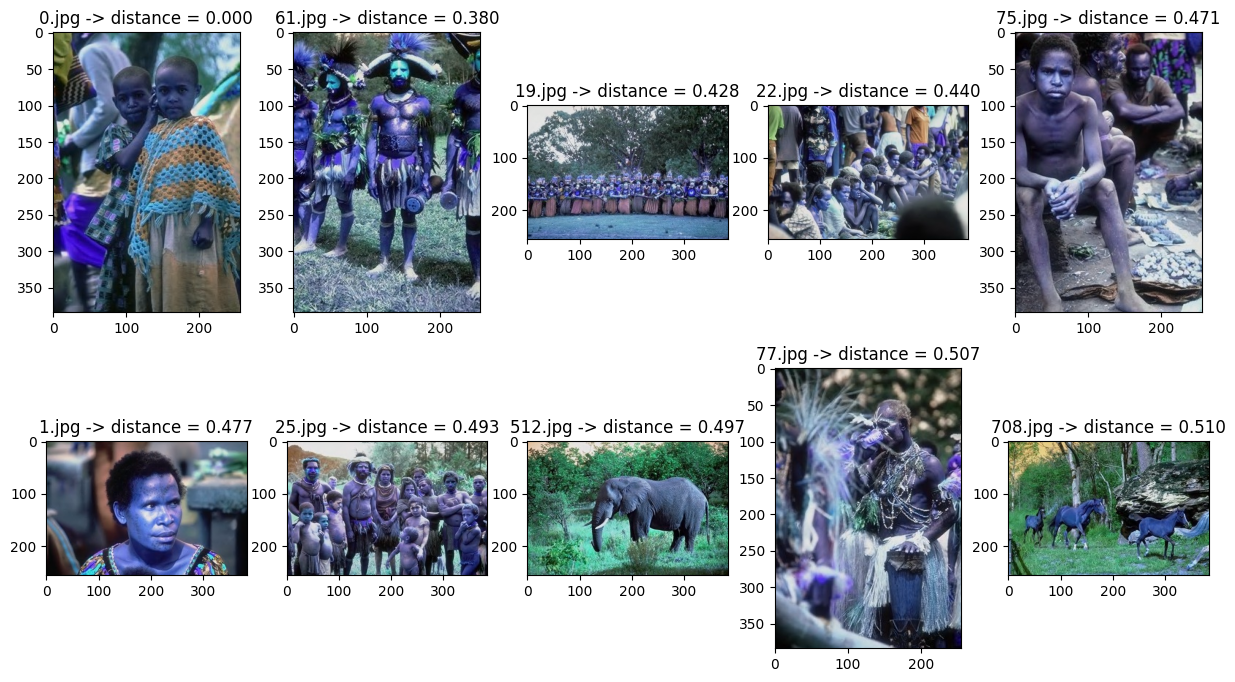

In [9]:
display_images(cbir_system, pins_list, queries_images_indices)

As shown above, the top 10 relevent images were displayed, 7/9 are from the same category with distances between 0.380 to 0.510 which are very good results and differences.

In [10]:
headers = ["Pins", "Threshold", "Precision", "Recall", "F1 Score", "Time"]
print(tabulate(metrics_table, headers=headers, tablefmt="pretty"))

+------+-----------+-----------+---------+----------+---------+
| Pins | Threshold | Precision | Recall  | F1 Score |  Time   |
+------+-----------+-----------+---------+----------+---------+
| 120  |    10     |  0.70000  | 0.07000 | 0.12727  | 0.60442 |
| 120  |    20     |  0.61500  | 0.12300 | 0.20500  | 0.77954 |
| 120  |    50     |  0.49600  | 0.24800 | 0.33067  | 1.59934 |
| 120  |    100    |  0.35900  | 0.35900 | 0.35900  | 0.93718 |
| 120  |    250    |  0.22480  | 0.56200 | 0.32114  | 1.33824 |
| 120  |    500    |  0.15060  | 0.75300 | 0.25100  | 1.06668 |
| ---  |  ------   |  -------  | ------- | -------  | ------- |
| 180  |    10     |  0.68000  | 0.06800 | 0.12364  | 1.36533 |
| 180  |    20     |  0.63500  | 0.12700 | 0.21167  | 0.92609 |
| 180  |    50     |  0.48200  | 0.24100 | 0.32133  | 1.04450 |
| 180  |    100    |  0.35100  | 0.35100 | 0.35100  | 0.66238 |
| 180  |    250    |  0.22320  | 0.55800 | 0.31886  | 0.54380 |
| 180  |    500    |  0.15140  | 0.75700

The table above shows the results of a the CBIR system evaluation with color histogram features, considering different numbers of pins and varying similarity thresholds. The metrics include precision, recall, F1 score, and the time taken for the evaluation.



*   *Precision and Recall*

Precision analyzes the accuracy of the retrieved photos, whereas recall assesses the system's ability to identify all relevant images. **Precision decreases with larger thresholds** in all configurations, demonstrating that as the system becomes more selective, precision drops. On the other hand, **recall often increases with higher thresholds**, indicating a larger retrieval of relevant images.

*   *F1-Score*

The F1-score is a harmonic average of precision and recall, which provides a fair assessment of the system's performance. It demonstrates a trade-off between precision and recall. As expected, **the threshold values that are closer to the number of images in the category produce greater F1-scores** -> when threshold = 100 we got the higher F1-score


*   *Time*

The time required for evaluate differs among configurations. **In general, the more pins there are, the more complex the feature vectors get, which means that more calculations are needed to determine distance or similarity.**  However, **the absence of a relationship across time in each configuration could be ascribed to the interactions of various additional elements.** A few examples of these elements can be the similarity threshold's effect, and how well the CBIR system is implemented.


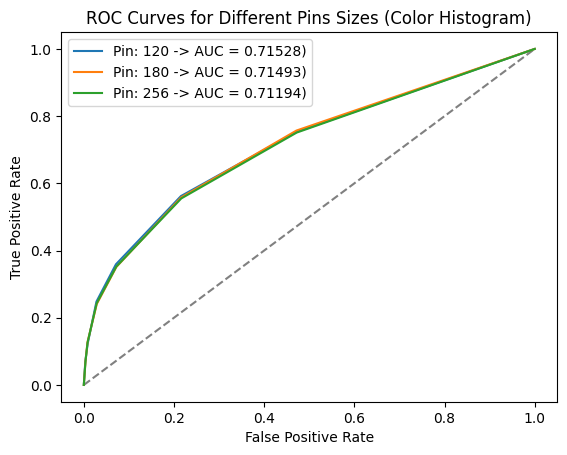

In [11]:
# plor roc curves
tpr_list = []
fpr_list = []
auc_list = []

for pins in pins_list:
  tpr, fpr, auc_val = calculate_tpr_fpr_auc(cbir_system, pins, thresholds_list, queries_images_indices)
  tpr_list.append(tpr)
  fpr_list.append(fpr)
  auc_list.append(auc_val)

plot_roc_curve(pins_list, tpr_list, fpr_list, auc_list)

The ROC curve analysis of the CBIR system, which uses pin configurations of 120, 180, and 256, tells a lot about the system. The AUC values of 0.71528, 0.71493, and 0.71194 for pin configurations 120, 180, and 256, respectively, indicate that the system effectively distinguishes between relevant and irrelevant images. The AUC values are close together, with a slight decrease as the pin value increases. This is because as the number of pins (features) increases, so does the dimensionality of the feature space, resulting in a sparser and more complex representation of the images, as well as the system becoming more sensitive to noise or variation in the dataset. Overall, these findings show a stable and balanced performance.

## **Task 3: System Implementation (Color Moments)**
in this task you need to experiment with color moments as following:

### **3.1:**
Implement the CBIR system using Color Moments (mean, standard deviation, and skewness) as an image representation. Use Euclidean as distant measure and assign equal weights to each moment. Compute precision, recall, F1 score, and time. Calculate the Area Under the Curve (AUC) to measure the overall performance across different threshold settings. Note that you need to compute these measures as an average of at least 10 different quires.

### Calculate Performance Metrics (precision, recall, f1-score, and time) Function

The `evaluate_performance_metrics_color_moments` function is implemented in the same way as the `evaluate_performance_metrics` with a few changes in the features, instead of using `get_color_histogram`, `get_color_moments` is used here with a equal weights (1,1,1) to get the color moments as features for all images in the dataset to compare between them and the query images.

All performance metrics are calculated in the same way as the previous function.

In [12]:
import time

# function to evaluate the precision, recall, f1-score, and time
def evaluate_performance_metrics_color_moments(cbir_system, threshold, queries_indices, weights=[1,1,1]):

  # get the start time
  start_time = time.time()

  # get the color moments for each image
  color_moments = []
  for image in cbir_system.dataset:
    color_moment = cbir_system.get_color_moments(image=image, weights=weights)
    color_moments.append(color_moment)

  time_before_queries = time.time() - start_time

  all_precisions = []
  all_recalls = []
  all_f1_scores = []
  all_queries_times = []

  for query_index in queries_indices:

    # query start time
    query_s_time = time.time()

    query_features = color_moments[query_index]

    # calculate the distances between each query and all other images
    distances = []
    for image_features in color_moments:
      distance = cbir_system.compute_euclidean_distance(query_features, image_features)
      distances.append(distance)

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # TP, FP, TN, and FN
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    # take the indices of least distances based on the threshold (number of images)
    retrieved_images_indices = ranked_results[0:threshold]

    # ex. query index 105 should be in the category 1 (105 // 100 = 1)
    # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
    query_category = query_index // 100
    category_range = range(query_category*100, (query_category*100) + 100)

    # calculate TP, FP, TN, and FN
    for index in retrieved_images_indices:
      # check if the image in the same category with the query image
      if index in category_range:
        # classified right (it is in the category and classified as in the category)
        true_positive += 1
      else:
        # classified wrong (it is not in the category but classified as in the category)
        false_positive += 1

    # number of images that should be classified in the same category but they're not
    false_negative = 100 - true_positive

    # number images that should not be classified in the same category and they're not
    true_negative = 900 - false_positive

    # query end time
    query_e_time = time.time()

    # calculate the performance metrics for the specific image query
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = (2 * precision * recall) / (precision + recall)
    query_time = query_e_time - query_s_time

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1_score)
    all_queries_times.append(query_time)

  # calculate the final average performance metrics
  avg_precision = sum(all_precisions) / len(all_precisions)
  avg_recall = sum(all_recalls) / len(all_recalls)
  avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)
  avg_query_time = sum(all_queries_times) / len(all_queries_times)
  whole_time = time_before_queries + avg_query_time

  return avg_precision, avg_recall, avg_f1_score, whole_time

### Calculate ROC and AUC Function

The `calculate_tpr_fpr_auc_color_moments` function is used for calculating the FPR, TPR, and AUC as explained in the `calculate_tpr_fpr_auc` previously. The only difference is that the color moments features which are 9 features here (3 moments * 3 channels) are used to calculate the distance instead of color histogram.

In [13]:
from sklearn.metrics import auc

def calculate_tpr_fpr_auc_color_moments(cbir_system, thresholds_list, queries_indices, weights=[1,1,1]):

  # get the color moments for each image
  color_moments = []
  for image in cbir_system.dataset:
    color_moment = cbir_system.get_color_moments(image=image, weights=weights)
    color_moments.append(color_moment)

  # first values 0, 0
  all_TPRs = [0]
  all_FPRs = [0]

  for threshold in thresholds_list:

    all_threshold_tprs = []
    all_threshold_fprs = []

    for query_index in queries_indices:

      query_features = color_moments[query_index]

      # calculate the distances between each query and all other images
      distances = []
      for image_features in color_moments:
        distance = cbir_system.compute_euclidean_distance(query_features, image_features)
        distances.append(distance)

      # get the sorted result indices
      ranked_results = cbir_system.rank_results(distances)

      # TP, FP, TN, and FN
      true_positive = 0
      false_positive = 0
      true_negative = 0
      false_negative = 0

      # take the indices of least distances based on the threshold (number of images)
      retrieved_images_indices = ranked_results[0:threshold]

      # ex. query index 105 should be in the category 1 (105 // 100 = 1)
      # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
      query_category = query_index // 100
      category_range = range(query_category*100, (query_category*100) + 100)

      # calculate TP, FP, TN, and FN
      for index in retrieved_images_indices:
        # check if the image in the same category with the query image
        if index in category_range:
          # classified right (it is in the category and classified as in the category)
          true_positive += 1
        else:
          # classified wrong (it is not in the category but classified as in the category)
          false_positive += 1

      # number of images that should be classified in the same category but they're not
      false_negative = 100 - true_positive

      # number images that should not be classified in the same category and they're not
      true_negative = 900 - false_positive

      # calculate true positive rates (tpr) and false positive rates (fpr)
      tpr = true_positive / (true_positive + false_negative)
      fpr = false_positive / (false_positive + true_negative)

      all_threshold_tprs.append(tpr)
      all_threshold_fprs.append(fpr)

    avg_tpr = sum(all_threshold_tprs) / len(all_threshold_tprs)
    avg_fpr = sum(all_threshold_fprs) / len(all_threshold_fprs)

    all_TPRs.append(avg_tpr)
    all_FPRs.append(avg_fpr)

  # last values 1, 1
  all_TPRs.append(1)
  all_FPRs.append(1)

  auc_val = auc(np.array(all_FPRs), np.array(all_TPRs))

  return all_TPRs, all_FPRs, auc_val

### Plot ROC Function

The `plot_roc_curve_color_moments` function is used for plotting the ROC curve for the different weights by using the previously calculated FPR and TPR as explained in the `plot_roc_curve` method previously.

In [14]:
import matplotlib.pyplot as plt

def plot_roc_curve_color_moments(tpr_list, fpr_list, auc_list, weights_list=[[1, 1, 1]]):

  # the diagonal line
  plt.plot([0, 1], [0, 1], '--', color='gray')

  for i in range(len(weights_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'{weights_list[i]}: AUC = {auc_list[i]:.5f})')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves for Color Moments')
  plt.legend()
  plt.show()

### Display 10 Images Function

The `display_images_cm` function is used for interactive displaying the top 10 relevent images to the selected query image.

In [15]:
import ipywidgets as widgets # for the widgets such as drop down menu
from IPython.display import display # for displaying the widgets
from IPython.display import clear_output # for clearing the output


def display_images_cm(cbir_system, queries_images_indices, weights_list=[[1,1,1]]):

  # let the user choose the query image index
  query_index_dropdown = widgets.Dropdown(
        options=[(f'{index}.jpg', index) for index in queries_images_indices],
        value=queries_images_indices[0],
        description='Select Query Image Index:'
    )

  # let the user choose the weight
  weights_dropdown = widgets.Dropdown(
        options=[(f'{weights}', weights) for weights in weights_list],
        value=weights_list[0],
        description='Select weight:'
    )

  # Button for triggering the display
  display_button = widgets.Button(description="Display Images")

  # Event handler for displaying images
  def on_button_click(b):

    clear_output(wait=True)
    display(query_index_dropdown)
    display(weights_dropdown)
    display(display_button)

    selected_query_index = query_index_dropdown.value
    selected_weights = weights_dropdown.value

    # get the color moments for each image based on the selected weights
    color_moments = [cbir_system.get_color_moments(image=image, weights=selected_weights) for image in cbir_system.dataset]

    # calculate distances between the query and all other images
    distances = [cbir_system.compute_euclidean_distance(color_moments[selected_query_index], image_moments) for image_moments in color_moments]

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # display the first 10 images
    rows, cols = 2, 5
    print("\nDisplaying Selected Images:")
    plt.figure(figsize=(15, 8))
    for i in range(rows):
      for j in range(cols):
        index = i * cols + j + 1
        plt.subplot(rows, cols, index)
        plt.imshow(cbir_system.dataset[ranked_results[index-1]])
        plt.title(f'{ranked_results[index-1]}.jpg -> distance = {distances[ranked_results[index-1]]:.3f}')
    plt.show()


  display_button.on_click(on_button_click)

  on_button_click(None)

### Task 3.1 Implementation

The code below initializes a CBIR system and systematically evaluates its performance with different retrieval thresholds.

The system is instantiated with a dataset of the previous downloaded images, and the evaluation retrieval thresholds of 10, 20, 50, 100, 250, and 500.

The query images selected cover the dataset at every category. For each threshold, the `evaluate_performance_metrics_color_moments` function is invoked, recording precision, recall, F1-score, and time taken.

The performance metrics are collected into a structured table using the tabulate library, offering an extensive understanding of the CBIR system's performance characteristics across various parameter settings.

In [16]:
from tabulate import tabulate # for the table format

# implement the CBIR system
cbir_system = CBIR_System(path='/content/image.orig')

thresholds_list = [10, 20, 50, 100, 250, 500]
# use the image 0.jpg, 101.jpg, 202.jpg, ..., 909.jpg for the queries
queries_images_indices = list(map(lambda i: i * 100 + i, range(10)))

metrics_table = []
for threshold in thresholds_list:
  precision, recall, f1_score, time_taken = evaluate_performance_metrics_color_moments(cbir_system, threshold, queries_images_indices)
  metrics_table.append([threshold, f'{precision:.5f}', f'{recall:.5f}', f'{f1_score:.5f}', f'{time_taken:.5f}'])
  metrics_table.append(['------', '-------', '-------', '-------', '-------'])

Dropdown(description='Select Query Image Index:', options=(('0.jpg', 0), ('101.jpg', 101), ('202.jpg', 202), (…

Dropdown(description='Select weight:', options=(('[1, 1, 1]', [1, 1, 1]),), value=[1, 1, 1])

Button(description='Display Images', style=ButtonStyle())


Displaying Selected Images:


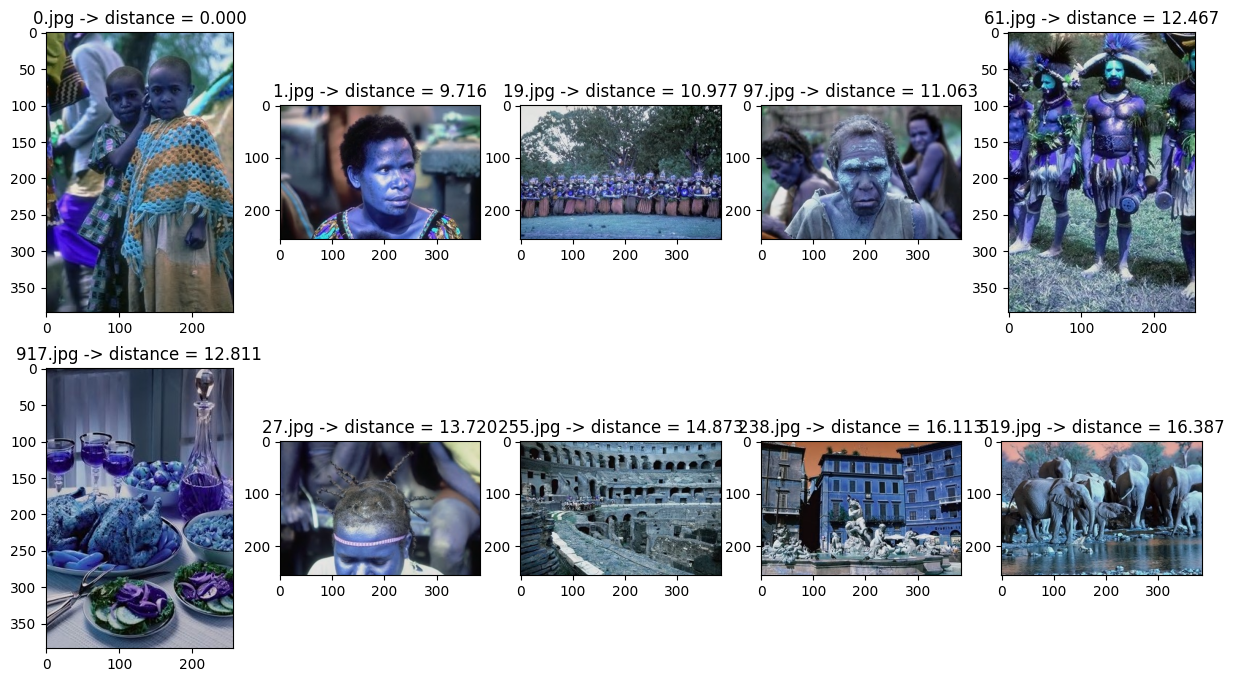

In [36]:
display_images_cm(cbir_system, queries_images_indices)

As shown above, the top 10 relevent images were displayed, 5/9 are from the same category with distances between 9.7 to 16.387. The results using color histogram were better for this query image.

In [18]:
headers = ["Threshold", "Precision", "Recall", "F1 Score", "Time"]
print(tabulate(metrics_table, headers=headers, tablefmt="pretty"))

+-----------+-----------+---------+----------+----------+
| Threshold | Precision | Recall  | F1 Score |   Time   |
+-----------+-----------+---------+----------+----------+
|    10     |  0.64000  | 0.06400 | 0.11636  | 30.29667 |
|  ------   |  -------  | ------- | -------  | -------  |
|    20     |  0.57000  | 0.11400 | 0.19000  | 28.43998 |
|  ------   |  -------  | ------- | -------  | -------  |
|    50     |  0.46000  | 0.23000 | 0.30667  | 28.45881 |
|  ------   |  -------  | ------- | -------  | -------  |
|    100    |  0.38000  | 0.38000 | 0.38000  | 28.59822 |
|  ------   |  -------  | ------- | -------  | -------  |
|    250    |  0.24160  | 0.60400 | 0.34514  | 29.28670 |
|  ------   |  -------  | ------- | -------  | -------  |
|    500    |  0.16720  | 0.83600 | 0.27867  | 29.33969 |
|  ------   |  -------  | ------- | -------  | -------  |
+-----------+-----------+---------+----------+----------+


The table above shows the results of a the CBIR system evaluation with color moments features, considering varying similarity thresholds. The metrics include precision, recall, F1 score, and the time taken for the evaluation.


*   *Precision and Recall*

Precision analyzes the accuracy of the retrieved photos, whereas recall assesses the system's ability to identify all relevant images. **Precision decreases with larger thresholds** in all configurations, demonstrating that as the system becomes more selective, precision drops. On the other hand, **recall often increases with higher thresholds**, indicating a larger retrieval of relevant images.

*   *F1-Score*

The F1-score is a harmonic average of precision and recall, which provides a fair assessment of the system's performance. It demonstrates a trade-off between precision and recall. As expected, **the threshold values that are closer to the number of images in the category produce greater F1-scores** -> when threshold = 100 we got the higher F1-score


*   *Time*

The time required for evaluate are very similar among configurations. The thresholds does not affect the required time because in all cases we have to calculate the distances between images and the query image, and changing the threshold does not change the time required for the evaluation.


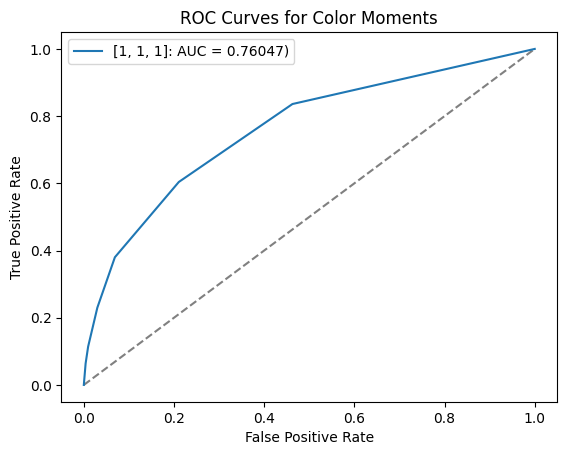

In [19]:
# plor roc curves
all_tpr = []
all_fpr = []
all_auc = []
tpr, fpr, auc_val = calculate_tpr_fpr_auc_color_moments(cbir_system, thresholds_list, queries_images_indices)
all_tpr.append(tpr)
all_fpr.append(fpr)
all_auc.append(auc_val)

plot_roc_curve_color_moments(all_tpr, all_fpr, all_auc)

The AUC value of 0.76047 for the CBIR system that uses color moment characteristics implies a strong ability to differentiate relevant images from irrelevant ones. This high AUC shows great overall performance, demonstrating the efficacy of color moment characteristics in collecting meaningful patterns within image data. The results highlight the system's ability to balance precision and memory, which is critical for accurate and efficient image retrieval.

### **3.2:**
Same as task 3.1 but with different weights. You need to give a weigh relative to the important of the moment.

### Task 3.2 Implementation

The code below initializes a CBIR system and systematically evaluates its performance with different weights and retrieval thresholds.

The system is instantiated with a dataset of the previous downloaded images, and the evaluation considers weights of [1, 1, 1], [1, 2, 3], [1, 4, 2], [1, 1, 5], as well as retrieval thresholds of 10, 20, 50, 100, 250, and 500.

The weights are used to assign a weight for each moment which they are mean, std, and skeweness respectively. This weights are used to give each moment a different priority.

The query images selected cover the dataset at every category. For each weights and threshold combination, the `evaluate_performance_metrics_color_moments` function is invoked, recording precision, recall, F1-score, and time taken.

The performance metrics are collected into a structured table using the tabulate library, offering an extensive understanding of the CBIR system's performance characteristics across various parameter settings.

In [20]:
from tabulate import tabulate

# implement the CBIR system
cbir_system = CBIR_System(path='/content/image.orig')

thresholds_list = [10, 20, 50, 100, 250, 500]
# use the image 0.jpg, 101.jpg, 202.jpg, ..., 909.jpg for the queries
queries_images_indices = list(map(lambda i: i * 100 + i, range(10)))

weights_list = [[1, 1, 1], [1, 2, 3], [1, 4, 2], [1, 1, 5]]

metrics_table = []
for weights in weights_list:
  for threshold in thresholds_list:
    precision, recall, f1_score, time_taken = evaluate_performance_metrics_color_moments(cbir_system, threshold, queries_images_indices, weights)
    metrics_table.append([weights, threshold, f'{precision:.5f}', f'{recall:.5f}', f'{f1_score:.5f}', f'{time_taken:.5f}'])
  metrics_table.append(['-----------','------', '-------', '-------', '-------', '-------'])

Dropdown(description='Select Query Image Index:', options=(('0.jpg', 0), ('101.jpg', 101), ('202.jpg', 202), (…

Dropdown(description='Select weight:', index=3, options=(('[1, 1, 1]', [1, 1, 1]), ('[1, 2, 3]', [1, 2, 3]), (…

Button(description='Display Images', style=ButtonStyle())


Displaying Selected Images:


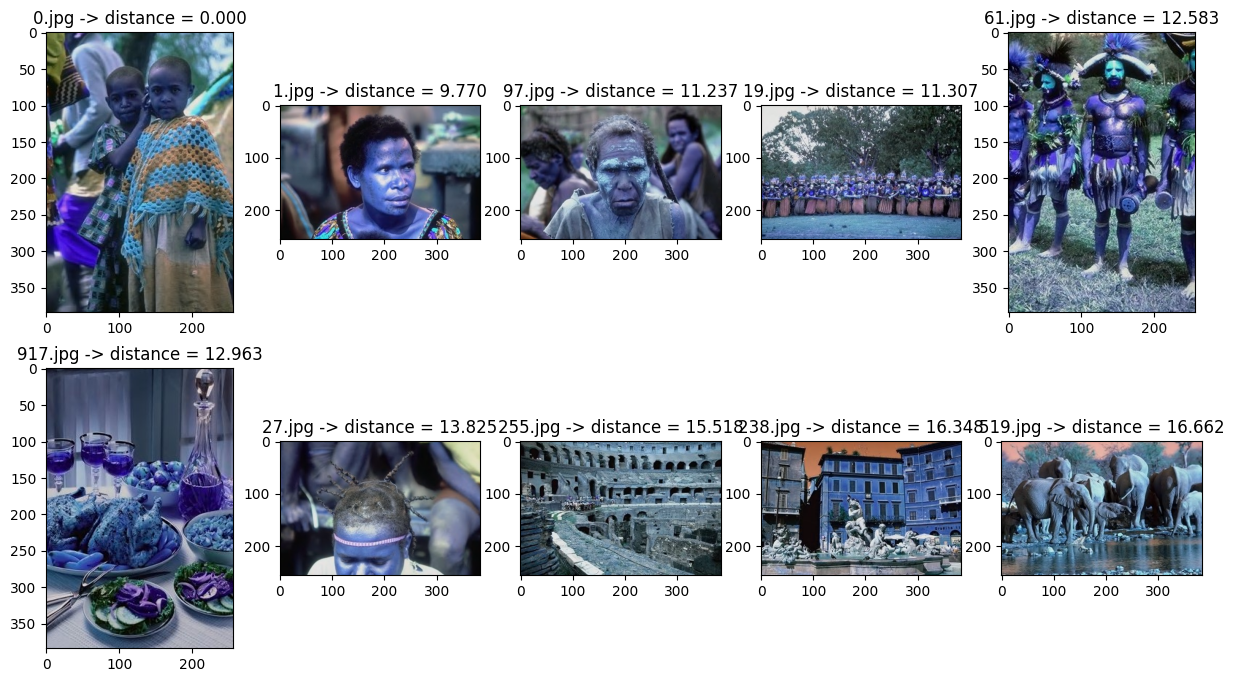

In [21]:
display_images_cm(cbir_system, queries_images_indices, weights_list)

As shown above, the top 10 relevent images were displayed, 5/9 are from the same category with distances between 9.770 to 16.662. The results using color histogram were better for this query image. while using the color moments with equal weights were very similar.

In [22]:
headers = ["Weights", "Threshold", "Precision", "Recall", "F1 Score", "Time"]
print(tabulate(metrics_table, headers=headers, tablefmt="pretty"))

+-------------+-----------+-----------+---------+----------+----------+
|   Weights   | Threshold | Precision | Recall  | F1 Score |   Time   |
+-------------+-----------+-----------+---------+----------+----------+
|  [1, 1, 1]  |    10     |  0.64000  | 0.06400 | 0.11636  | 35.94220 |
|  [1, 1, 1]  |    20     |  0.57000  | 0.11400 | 0.19000  | 39.58948 |
|  [1, 1, 1]  |    50     |  0.46000  | 0.23000 | 0.30667  | 28.57946 |
|  [1, 1, 1]  |    100    |  0.38000  | 0.38000 | 0.38000  | 29.26585 |
|  [1, 1, 1]  |    250    |  0.24160  | 0.60400 | 0.34514  | 37.12209 |
|  [1, 1, 1]  |    500    |  0.16720  | 0.83600 | 0.27867  | 29.60791 |
| ----------- |  ------   |  -------  | ------- | -------  | -------  |
|  [1, 2, 3]  |    10     |  0.66000  | 0.06600 | 0.12000  | 28.27317 |
|  [1, 2, 3]  |    20     |  0.55000  | 0.11000 | 0.18333  | 34.71593 |
|  [1, 2, 3]  |    50     |  0.42400  | 0.21200 | 0.28267  | 29.57715 |
|  [1, 2, 3]  |    100    |  0.36600  | 0.36600 | 0.36600  | 31.

The table above shows the results of a the CBIR system evaluation with color moments features using different weights, considering varying similarity thresholds. The metrics include precision, recall, F1 score, and the time taken for the evaluation.


*   *Precision and Recall*

Precision analyzes the accuracy of the retrieved photos, whereas recall assesses the system's ability to identify all relevant images. **Precision decreases with larger thresholds** in all configurations, demonstrating that as the system becomes more selective, precision drops. On the other hand, **recall often increases with higher thresholds**, indicating a larger retrieval of relevant images.

*   *F1-Score*

The F1-score is a harmonic average of precision and recall, which provides a fair assessment of the system's performance. It demonstrates a trade-off between precision and recall. As expected, **the threshold values that are closer to the number of images in the category produce greater F1-scores** -> when threshold = 100 we got the higher F1-score


*   *Time*

**The time required for evaluate are very similar among configurations.** The thresholds and weights does not affect the required time because in all cases we have to calculate the distances between images and the query image, and changing the threshold or weights does not have a significant impact on the time required for the evaluation.


*   *Impact of Weights*

**The choice of weight has a considerable impact on the system performance.** For example, higher weights applied to specific color the tird moment (skeweness) (e.g., [1, 1, 5]) improved the performance. In contrast, giving std higher weight worsen the system(e.g., [1, 4, 2]).


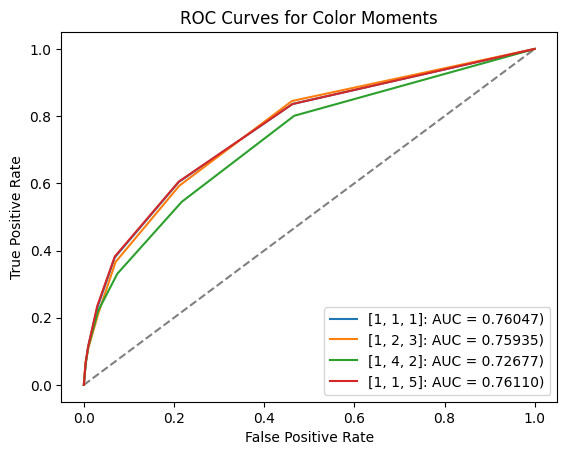

In [23]:
# plot roc curves
all_tpr = []
all_fpr = []
all_auc = []
for weights in weights_list:
  tpr, fpr, auc_val = calculate_tpr_fpr_auc_color_moments(cbir_system, thresholds_list, queries_images_indices, weights)
  all_tpr.append(tpr)
  all_fpr.append(fpr)
  all_auc.append(auc_val)

plot_roc_curve_color_moments(all_tpr, all_fpr, all_auc, weights_list)

The results above show nuanced differences in discriminative performance. The Area Under the Curve (AUC) figures demonstrate the influence of weighting the mean, standard deviation, and skewness of color moments. The [1,1,1] and [1,1,5] configurations have significant discriminative capabilities, indicating that emphasizing all color moments equally or weighing skewness more heavily improves retrieval efficacy. In contrast, the [1,4,2] design exhibits a modest decrease in discriminative performance, underscoring the system's sensitivity to the weight distribution. These findings highlight the importance of proper weight assignment for developing the CBIR system for accurate and efficient picture retrieval tasks.

### **3.3:**
Same as task 3.2 but with the addition of more Moments including Median, Mode, and Kurtosis.

### Task 3.3 Implementation

This code is very similar to the previous codes in tasks 3.2 and 3.1. The difference is that we used more than 3 moments (we added the median, the mode, and the kurtosis moments) and we assigned weights to them.

Then, the performance is calculated and displayed. As well as the ROC and AUC.

In [24]:
from tabulate import tabulate

# implement the CBIR system
cbir_system = CBIR_System(path='/content/image.orig')

thresholds_list = [10, 20, 50, 100, 250, 500]
# use the image 0.jpg, 101.jpg, 202.jpg, ..., 909.jpg for the queries
queries_images_indices = list(map(lambda i: i * 100 + i, range(10)))

weights_list = [[1, 1, 1, 1, 1, 1], [1, 2, 3, 1, 2, 3], [1, 1, 5, 1, 2, 1]]

metrics_table = []
for weights in weights_list:
  for threshold in thresholds_list:
    precision, recall, f1_score, time_taken = evaluate_performance_metrics_color_moments(cbir_system, threshold, queries_images_indices, weights)
    metrics_table.append([weights, threshold, f'{precision:.5f}', f'{recall:.5f}', f'{f1_score:.5f}', f'{time_taken:.5f}'])
  metrics_table.append(['-----------','------', '-------', '-------', '-------', '-------'])

Dropdown(description='Select Query Image Index:', options=(('0.jpg', 0), ('101.jpg', 101), ('202.jpg', 202), (…

Dropdown(description='Select weight:', index=2, options=(('[1, 1, 1, 1, 1, 1]', [1, 1, 1, 1, 1, 1]), ('[1, 2, …

Button(description='Display Images', style=ButtonStyle())


Displaying Selected Images:


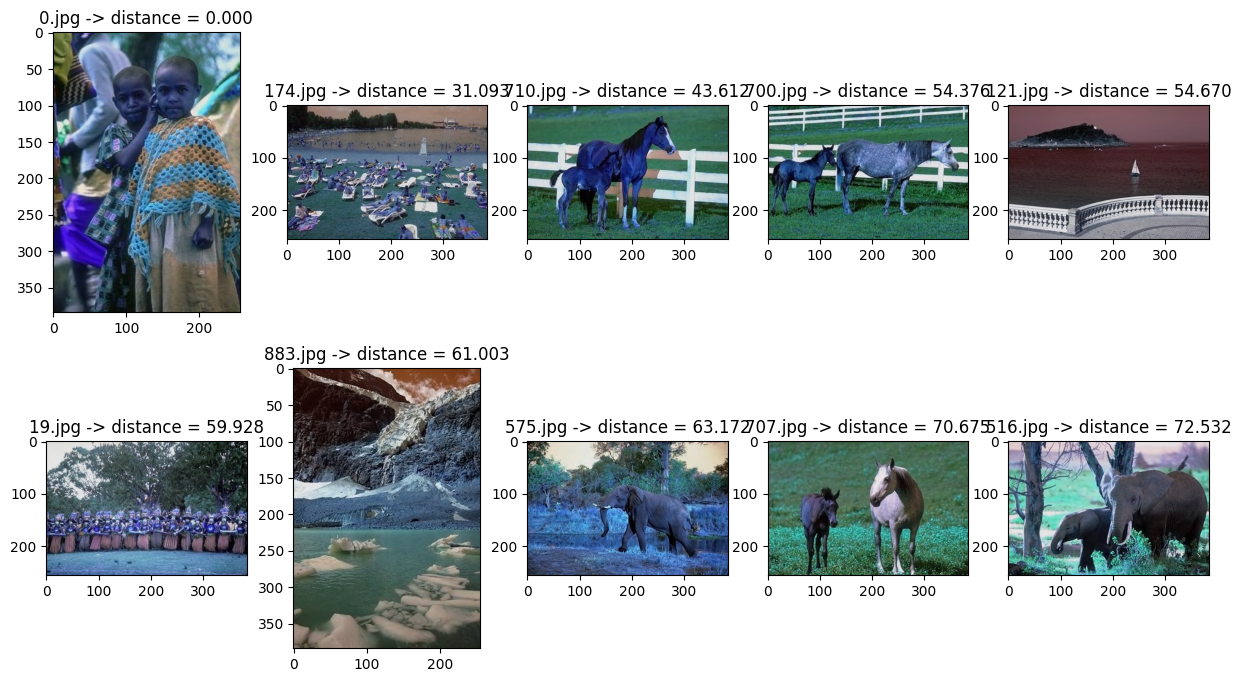

In [25]:
display_images_cm(cbir_system, queries_images_indices, weights_list)

As shown above, the top 10 relevent images were displayed, 1/9 is from the same category with distances between 31.093 to 72.532. The results using both color histogram and with color moments with less moments were better for this query image.

In [26]:
headers = ["Weights", "Threshold", "Precision", "Recall", "F1 Score", "Time"]
print(tabulate(metrics_table, headers=headers, tablefmt="pretty"))

+--------------------+-----------+-----------+---------+----------+----------+
|      Weights       | Threshold | Precision | Recall  | F1 Score |   Time   |
+--------------------+-----------+-----------+---------+----------+----------+
| [1, 1, 1, 1, 1, 1] |    10     |  0.65000  | 0.06500 | 0.11818  | 30.17408 |
| [1, 1, 1, 1, 1, 1] |    20     |  0.52500  | 0.10500 | 0.17500  | 28.07313 |
| [1, 1, 1, 1, 1, 1] |    50     |  0.42000  | 0.21000 | 0.28000  | 28.34874 |
| [1, 1, 1, 1, 1, 1] |    100    |  0.36600  | 0.36600 | 0.36600  | 34.89541 |
| [1, 1, 1, 1, 1, 1] |    250    |  0.23720  | 0.59300 | 0.33886  | 28.07349 |
| [1, 1, 1, 1, 1, 1] |    500    |  0.15580  | 0.77900 | 0.25967  | 28.33698 |
|    -----------     |  ------   |  -------  | ------- | -------  | -------  |
| [1, 2, 3, 1, 2, 3] |    10     |  0.62000  | 0.06200 | 0.11273  | 29.93687 |
| [1, 2, 3, 1, 2, 3] |    20     |  0.51500  | 0.10300 | 0.17167  | 28.27609 |
| [1, 2, 3, 1, 2, 3] |    50     |  0.40200  | 0.201

The table above shows the results of a the CBIR system evaluation with color moments features adding more moments, using different weights, and considering varying similarity thresholds. The metrics include precision, recall, F1 score, and the time taken for the evaluation.


*   *Precision and Recall*

Precision analyzes the accuracy of the retrieved photos, whereas recall assesses the system's ability to identify all relevant images. **Precision decreases with larger thresholds** in all configurations, demonstrating that as the system becomes more selective, precision drops. On the other hand, **recall often increases with higher thresholds**, indicating a larger retrieval of relevant images.

*   *F1-Score*

The F1-score is a harmonic average of precision and recall, which provides a fair assessment of the system's performance. It demonstrates a trade-off between precision and recall. As expected, **the threshold values that are closer to the number of images in the category produce greater F1-scores** -> when threshold = 100 we got the higher F1-score


*   *Time*

**The time required for evaluate are very similar among configurations.** The thresholds and weights does not affect the required time because in all cases we have to calculate the distances between images and the query image, and changing the threshold or weights does not have a significant impact on the time required for the evaluation.


*   *Impact of Weights*

**The choice of weight has a considerable impact on the system performance.** For example, higher weights applied to specific color the tird and fifth moment(skeweness, and kurtosis) (e.g., [1, 2, 3, 1, 2, 3]) improved the performance. In contrast, giving equal weights worsen the system(e.g., [1, 1, 1, 1, 1, 1]).

*   *Impact of Additional Moments*

**The addition of new statistical moments, such as median, mode, and kurtosis, to mean, standard deviation, and skewness, results in slight changes** in precision, recall, and F1 score. The [1, 1, 1, 1, 1, 1] configuration, which includes these additional moments, demonstrates differences in performance measures with comparison between the performance in the previous task when the weights were [1, 1, 1] whereas the less moments gave better performance, emphasizing the importance of careful consideration when expanding the feature set. These findings highlight the complex interplay of weights and other statistical moments in optimizing the CBIR system for image retrieval tasks.



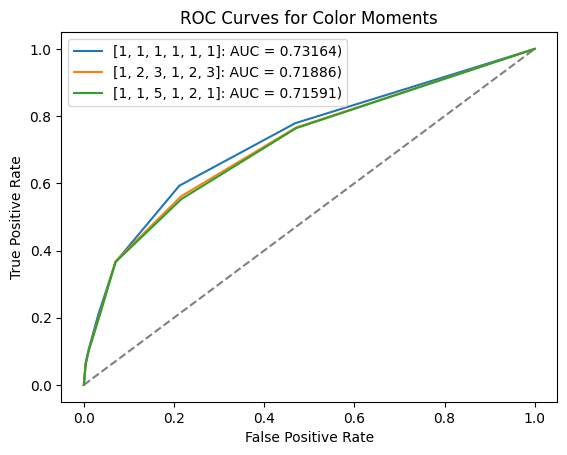

In [27]:
# plot roc curves
all_tpr = []
all_fpr = []
all_auc = []
for weights in weights_list:
  tpr, fpr, auc_val = calculate_tpr_fpr_auc_color_moments(cbir_system, thresholds_list, queries_images_indices, weights)
  all_tpr.append(tpr)
  all_fpr.append(fpr)
  all_auc.append(auc_val)

plot_roc_curve_color_moments(all_tpr, all_fpr, all_auc, weights_list)

The AUC values for various weight configurations ([1,1,1,1,1,1], [1,2,3,1,2,3], [1,1,5,1,2,1]) show slight variations in the discriminative performance of the CBIR system. The configuration [1,1,1,1,1,1], with equal weights, has a highest AUC of 0.73164, demonstrating a strong capacity to differentiate between important and irrelevant images. The configuration [1,2,3,1,2,3], which includes different weights and additional statistical moments, performs similarly with an AUC of 0.71886, demonstrating competitive discriminative performance. The [1,1,5,1,2,1] configuration, which emphasizes skewness and kurtosis, has a little weaker AUC of 0.71591 but is still a standout performer. These findings highlight the effect of weight configurations on the CBIR system's ability to efficiently discriminate and recall images, underlining the significance of careful weight assignment for peak performance.


## **Task 4: Improvement CBIR System**
Try to improve the performance of the CBIR system using other image representation techniques.

The Local Binary Pattern (LBP) approach is a texture descriptor that is commonly used to characterize local patterns and structures within an image. The LBP is developed for texture classification, and it focuses on the correlations between pixel intensities in a small neighborhood. The main idea is to encode the local contrast information by comparing the intensity of each pixel to its neighbors. In the LBP procedure, each pixel is assigned a binary code based on whether its neighbors have greater or lower intensity values than the central pixel. The generated binary patterns are then used to generate a histogram, which depicts the distribution of these patterns over the image.

LBP is well-known for its simplicity, computational efficiency, and resistance to changes in lighting, making it ideal for a variety of applications including face recognition, texture analysis, and object detection. The effectiveness of it comes from its capacity to detect unique textural elements, making it an important tool in the arsenal of image processing approaches.


### Calculate Performance Metrics (precision, recall, f1-score, and time) Function

In [28]:
import time

# function to evaluate the precision, recall, f1-score, and time
def evaluate_performance_metrics_lbp(cbir_system, threshold, queries_indices):

  # get the start time
  start_time = time.time()

  # get the LBP features for each image
  images_features = []
  for image in cbir_system.dataset:
    feature = cbir_system.get_lbp_features(image=image)
    images_features.append(feature)

  time_before_queries = time.time() - start_time

  all_precisions = []
  all_recalls = []
  all_f1_scores = []
  all_queries_times = []

  for query_index in queries_indices:

    # query start time
    query_s_time = time.time()

    query_features = images_features[query_index]

    # calculate the distances between each query and all other images
    distances = []
    for image_features in images_features:
      distance = cbir_system.compute_euclidean_distance(query_features, image_features)
      distances.append(distance)

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # TP, FP, TN, and FN
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    # take the indices of least distances based on the threshold (number of images)
    retrieved_images_indices = ranked_results[0:threshold]

    # ex. query index 105 should be in the category 1 (105 // 100 = 1)
    # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
    query_category = query_index // 100
    category_range = range(query_category*100, (query_category*100) + 100)

    # calculate TP, FP, TN, and FN
    for index in retrieved_images_indices:
      # check if the image in the same category with the query image
      if index in category_range:
        # classified right (it is in the category and classified as in the category)
        true_positive += 1
      else:
        # classified wrong (it is not in the category but classified as in the category)
        false_positive += 1

    # number of images that should be classified in the same category but they're not
    false_negative = 100 - true_positive

    # number images that should not be classified in the same category and they're not
    true_negative = 900 - false_positive

    # query end time
    query_e_time = time.time()

    # calculate the performance metrics for the specific image query
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = (2 * precision * recall) / (precision + recall)
    query_time = query_e_time - query_s_time

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1_score)
    all_queries_times.append(query_time)

  # calculate the final average performance metrics
  avg_precision = sum(all_precisions) / len(all_precisions)
  avg_recall = sum(all_recalls) / len(all_recalls)
  avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)
  avg_query_time = sum(all_queries_times) / len(all_queries_times)
  whole_time = time_before_queries + avg_query_time

  return avg_precision, avg_recall, avg_f1_score, whole_time

### Calculate ROC and AUC Function

In [29]:
from sklearn.metrics import auc

def calculate_tpr_fpr_auc_lbp(cbir_system, thresholds_list, queries_indices):

  # get the LBP features for each image
  images_features = []
  for image in cbir_system.dataset:
    features = cbir_system.get_lbp_features(image=image)
    images_features.append(features)

  # first values 0, 0
  all_TPRs = [0]
  all_FPRs = [0]

  for threshold in thresholds_list:

    all_threshold_tprs = []
    all_threshold_fprs = []

    for query_index in queries_indices:

      query_features = images_features[query_index]

      # calculate the distances between each query and all other images
      distances = []
      for image_features in images_features:
        distance = cbir_system.compute_euclidean_distance(query_features, image_features)
        distances.append(distance)

      # get the sorted result indices
      ranked_results = cbir_system.rank_results(distances)

      # TP, FP, TN, and FN
      true_positive = 0
      false_positive = 0
      true_negative = 0
      false_negative = 0

      # take the indices of least distances based on the threshold (number of images)
      retrieved_images_indices = ranked_results[0:threshold]

      # ex. query index 105 should be in the category 1 (105 // 100 = 1)
      # and images range in this category should be [100, 200) -> [(1*100), (1*100 + 100))
      query_category = query_index // 100
      category_range = range(query_category*100, (query_category*100) + 100)

      # calculate TP, FP, TN, and FN
      for index in retrieved_images_indices:
        # check if the image in the same category with the query image
        if index in category_range:
          # classified right (it is in the category and classified as in the category)
          true_positive += 1
        else:
          # classified wrong (it is not in the category but classified as in the category)
          false_positive += 1

      # number of images that should be classified in the same category but they're not
      false_negative = 100 - true_positive

      # number images that should not be classified in the same category and they're not
      true_negative = 900 - false_positive

      # calculate true positive rates (tpr) and false positive rates (fpr)
      tpr = true_positive / (true_positive + false_negative)
      fpr = false_positive / (false_positive + true_negative)

      all_threshold_tprs.append(tpr)
      all_threshold_fprs.append(fpr)

    avg_tpr = sum(all_threshold_tprs) / len(all_threshold_tprs)
    avg_fpr = sum(all_threshold_fprs) / len(all_threshold_fprs)

    all_TPRs.append(avg_tpr)
    all_FPRs.append(avg_fpr)

  # last values 1, 1
  all_TPRs.append(1)
  all_FPRs.append(1)

  auc_val = auc(np.array(all_FPRs), np.array(all_TPRs))

  return all_TPRs, all_FPRs, auc_val

### Plot ROC Function

In [30]:
import matplotlib.pyplot as plt

def plot_roc_curve_lbp(tpr_list, fpr_list, auc_list):

  # the diagonal line
  plt.plot([0, 1], [0, 1], '--', color='gray')

  plt.plot(fpr_list, tpr_list, label=f'AUC = {auc_list:.5f})')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves for LBP')
  plt.legend()
  plt.show()

### Display 10 Images Function

In [31]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output


def display_images_lbp(cbir_system, queries_images_indices):

  # let the user choose the query image index
  query_index_dropdown = widgets.Dropdown(
        options=[(f'{index}.jpg', index) for index in queries_images_indices],
        value=queries_images_indices[0],
        description='Select Query Image Index:'
    )

  # Button for triggering the display
  display_button = widgets.Button(description="Display Images")

  # Event handler for displaying images
  def on_button_click(b):

    clear_output(wait=True)
    display(query_index_dropdown)
    display(display_button)

    selected_query_index = query_index_dropdown.value

    # get the color moments for each image
    images_features = [cbir_system.get_lbp_features(image) for image in cbir_system.dataset]

    # calculate distances between the query and all other images
    distances = [cbir_system.compute_euclidean_distance(images_features[selected_query_index], image_features) for image_features in images_features]

    # get the sorted result indices
    ranked_results = cbir_system.rank_results(distances)

    # display the first 10 images
    rows, cols = 2, 5
    print("\nDisplaying Selected Images:")
    plt.figure(figsize=(15, 8))
    for i in range(rows):
      for j in range(cols):
        index = i * cols + j + 1
        plt.subplot(rows, cols, index)
        plt.imshow(cbir_system.dataset[ranked_results[index-1]])
        plt.title(f'{ranked_results[index-1]}.jpg -> distance = {distances[ranked_results[index-1]]:.3f}')
    plt.show()


  display_button.on_click(on_button_click)

  on_button_click(None)

### Task 4 Implementation

In [32]:
from tabulate import tabulate

# implement the CBIR system
cbir_system = CBIR_System(path='/content/image.orig')

thresholds_list = [10, 20, 50, 100, 250, 500]
# use the image 0.jpg, 101.jpg, 202.jpg, ..., 909.jpg for the queries
queries_images_indices = list(map(lambda i: i * 100 + i, range(10)))

metrics_table = []
for threshold in thresholds_list:
  precision, recall, f1_score, time_taken = evaluate_performance_metrics_lbp(cbir_system, threshold, queries_images_indices)
  metrics_table.append([threshold, f'{precision:.5f}', f'{recall:.5f}', f'{f1_score:.5f}', f'{time_taken:.5f}'])
  metrics_table.append(['------', '-------', '-------', '-------', '-------'])

Dropdown(description='Select Query Image Index:', options=(('0.jpg', 0), ('101.jpg', 101), ('202.jpg', 202), (…

Button(description='Display Images', style=ButtonStyle())


Displaying Selected Images:


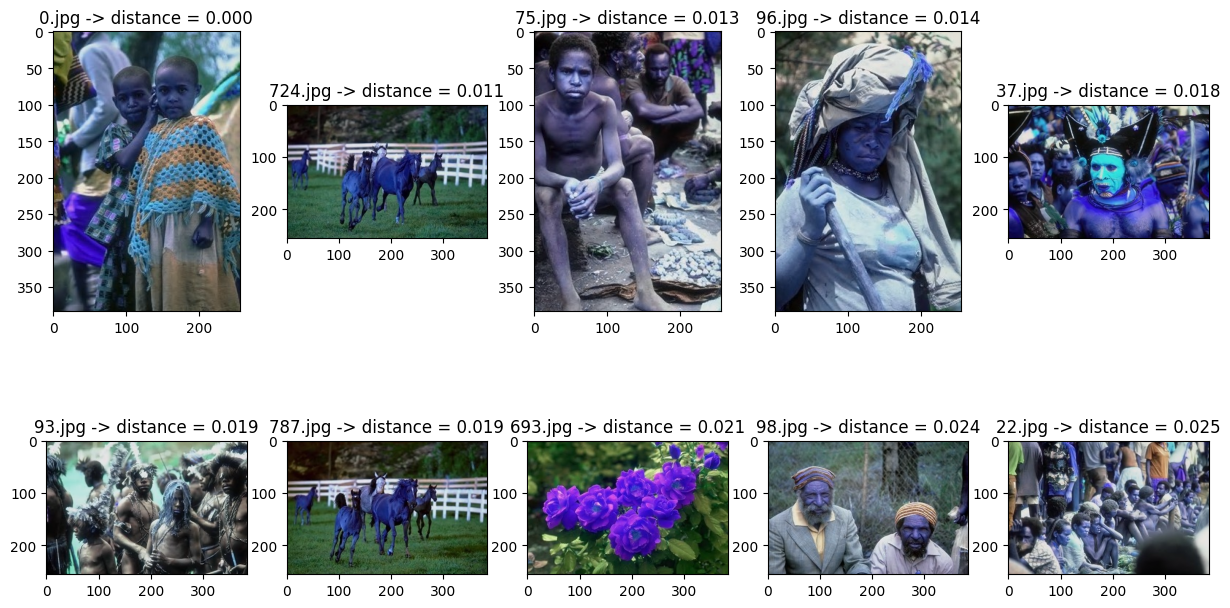

In [33]:
display_images_lbp(cbir_system, queries_images_indices)

As shown above, the top 10 relevent images were displayed, 6/9 is from the same category with distances between 0.011 to 0.025. The results using color histogram were better for this query image. But they are better than the color moments for this query.

In [34]:
headers = ["Threshold", "Precision", "Recall", "F1 Score", "Time"]
print(tabulate(metrics_table, headers=headers, tablefmt="pretty"))

+-----------+-----------+---------+----------+----------+
| Threshold | Precision | Recall  | F1 Score |   Time   |
+-----------+-----------+---------+----------+----------+
|    10     |  0.68000  | 0.06800 | 0.12364  | 26.33049 |
|  ------   |  -------  | ------- | -------  | -------  |
|    20     |  0.58500  | 0.11700 | 0.19500  | 24.07855 |
|  ------   |  -------  | ------- | -------  | -------  |
|    50     |  0.50200  | 0.25100 | 0.33467  | 26.59264 |
|  ------   |  -------  | ------- | -------  | -------  |
|    100    |  0.42000  | 0.42000 | 0.42000  | 35.80889 |
|  ------   |  -------  | ------- | -------  | -------  |
|    250    |  0.23600  | 0.59000 | 0.33714  | 24.05044 |
|  ------   |  -------  | ------- | -------  | -------  |
|    500    |  0.16100  | 0.80500 | 0.26833  | 23.27681 |
|  ------   |  -------  | ------- | -------  | -------  |
+-----------+-----------+---------+----------+----------+


The table above shows the results of a the CBIR system evaluation with  Local Binary Pattern (LBP) features considering varying similarity thresholds. The metrics include precision, recall, F1 score, and the time taken for the evaluation.


*   *Precision and Recall*

Precision analyzes the accuracy of the retrieved photos, whereas recall assesses the system's ability to identify all relevant images. **Precision decreases with larger thresholds** in all configurations, demonstrating that as the system becomes more selective, precision drops. On the other hand, **recall often increases with higher thresholds**, indicating a larger retrieval of relevant images.

*   *F1-Score*

The F1-score is a harmonic average of precision and recall, which provides a fair assessment of the system's performance. It demonstrates a trade-off between precision and recall. As expected, **the threshold values that are closer to the number of images in the category produce greater F1-scores** -> when threshold = 100 we got the higher F1-score


*   *Time*

**The time required for evaluate are very similar among configurations.** The thresholds does not affect the required time because in all cases we have to calculate the distances between images and the query image, and changing the threshold does not have a significant impact on the time required for the evaluation. Also, the time is similar because the points and radious are fixed, changing them will lead to the change the evaluation time (Positive relationship).



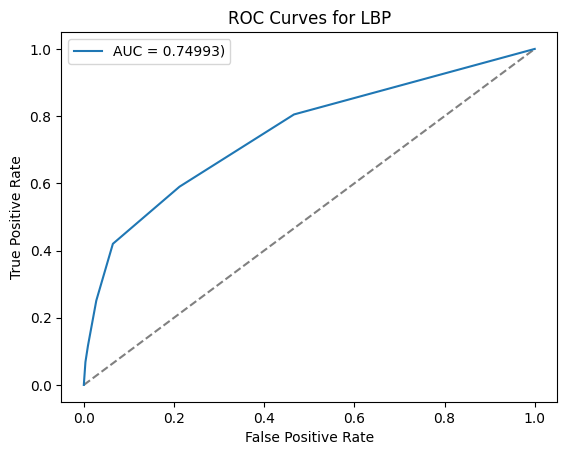

In [35]:
# plot roc curves
tpr, fpr, auc_val = calculate_tpr_fpr_auc_lbp(cbir_system, thresholds_list, queries_images_indices)

plot_roc_curve_lbp(tpr, fpr, auc_val)

An AUC value of 0.74993 shows that the CBIR system, which uses the Local Binary Pattern (LBP) technique, is reasonably effective in distinguishing between relevant and irrelevant images. This shows good discriminative performance, while additional tuning of dataset representation and similarity measures could improve overall system efficacy.

## **Conclusion**

This work presents a comprehensive comparison of various Content-Based Image Retrieval (CBIR) systems that use different feature sets, such as color histogram, color moments with different moment numbers and weights, and Local Binary Pattern (LBP). It also identifies key advantages and disadvantages.



*   **Color Histogram**

Across a range of thresholds, the color histogram showed consistent performance, offering a solid and dependable basis for picture retrieval tasks.

*   **Color Moments**

*Effect of Adding More Moments:* The representational capacity of color moments was increased by the addition of additional moments, such as kurtosis, median, and mode. This enlargement of the picture content beyond the standard deviation, skewness, and mean yielded a more detailed and thorough description.

*Effect of Weight Configurations:* Color moments' sensitivity to these parameters was highlighted by the experiment using various weight configurations. Increased weights allocated to particular moments, particularly skewness, shown a noteworthy impact on system efficiency, underscoring the importance of customized setups.

The flexibility of color moments in adapting to various CBIR settings was demonstrated by the capacity to add new moments and change their weights. Although this flexibility has benefits, it also necessitates challenging optimization in order to fully utilize the feature set for particular applications.


*   **Local Binary Pattern (LBP)**

Across a range of similarity thresholds, the Local Binary Pattern (LBP) technique showed a stable and dependable performance in identifying pertinent photos. Its simple method of obtaining local texture patterns worked well for challenges CBIR. The robustness of LBP characteristics is indicated by the constancy of the precision and recall trade-offs as thresholds increased. The simplicity and dependability of LBP make it a good option for some CBIR applications, especially those that emphasize local texture qualities, even though it lacks the intricacy of more sophisticated features. Subsequent investigation could entail merging LBP with additional feature sets to leverage complementary advantages for improved retrieval outcomes across various picture repositories.


***So, what is the optimal method?***

The best approach will vary depending on the application's need for computing efficiency, the type of image dataset, and the particular features that tell each image apart in your context. To maximize the benefits of various attributes for better retrieval performance, try experimenting with different techniques or hybrid approaches.

In [37]:
from tabulate import tabulate

headers = ["Feature Set", "Strengths", "Limitations"]

data = [
    ["Color Histogram", "- Stable performance across thresholds", "- Limited expressive power compared to more advanced features"],
    ["Color Moments", "- Flexibility with moment configurations", "- Sensitive to moment and weight choices"],
    ["Local Binary Pattern", "- Stable precision and recall trade-offs", "- May lack the expressiveness of more complex features"]
]

table = tabulate(data, headers, tablefmt="pipe")
print(table)

| Feature Set          | Strengths                                | Limitations                                                   |
|:---------------------|:-----------------------------------------|:--------------------------------------------------------------|
| Color Histogram      | - Stable performance across thresholds   | - Limited expressive power compared to more advanced features |
| Color Moments        | - Flexibility with moment configurations | - Sensitive to moment and weight choices                      |
| Local Binary Pattern | - Stable precision and recall trade-offs | - May lack the expressiveness of more complex features        |


### **Limitations and Potential Improvements**
Future improvements are made possible by acknowledging the limits of the current work, which include the need for more diverse datasets and benchmarking against sophisticated techniques. Further improvements in scalability, efficiency, and the investigation of deep learning architectures could lead to even higher performance levels for CBIR systems.

### **Further Research**
Following studies steps have to concentrate on enhancing feature engineering strategies, investigating hybrid ways that integrate the advantages of diverse feature sets, and conducting benchmarking against the most advanced methodologies. Furthermore, the practical usability of CBIR systems will be improved by addressing potential restrictions, such as the influence of dataset features and system efficiency.



### **Overall Conclusions**
It is clear that color features are useful for CBIR activities, and each feature set has special benefits. LBP exhibits stability in precision and recall trade-offs, color moments allow flexibility with moment configurations, and color histograms offer simplicity and dependability.
